Jelle, July 2016

In [1]:
import numpy as np
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

import pandas as pd

This notebook contains the code that made the data files in the xenon/data directory.

# S1 (r^2, z) LCE map

In [2]:
from pax import InterpolatingMap, configuration, utils
pax_config = configuration.load_configuration('XENON1T')
mapfile = utils.data_file_name(pax_config['WaveformSimulator']['s1_light_yield_map'])
s1_map = InterpolatingMap.InterpolatingMap(mapfile)

In [3]:
from multihist import Histdd

In [14]:
s1_map.get_value?

In [20]:
mh = Histdd(axis_names=['r2', 'z'],
            bins=(np.linspace(0, pax_config['DEFAULT']['tpc_radius']**2, 50),
                  np.linspace(-pax_config['DEFAULT']['tpc_length'], 0, 100)))

for i, r2 in enumerate(tqdm(mh.bin_centers(axis='r2'))):
    for j, z in enumerate(mh.bin_centers(axis='z')):
        vs = np.ones(10)
        for k, q in enumerate(np.linspace(0, 2*np.pi, len(v))):
            x = np.sqrt(r2) * np.cos(q)
            y = np.sqrt(r2) * np.sin(q)
            vs[k] = s1_map.get_value(x, y, z)
        mh.histogram[i,j] = vs.mean()
        

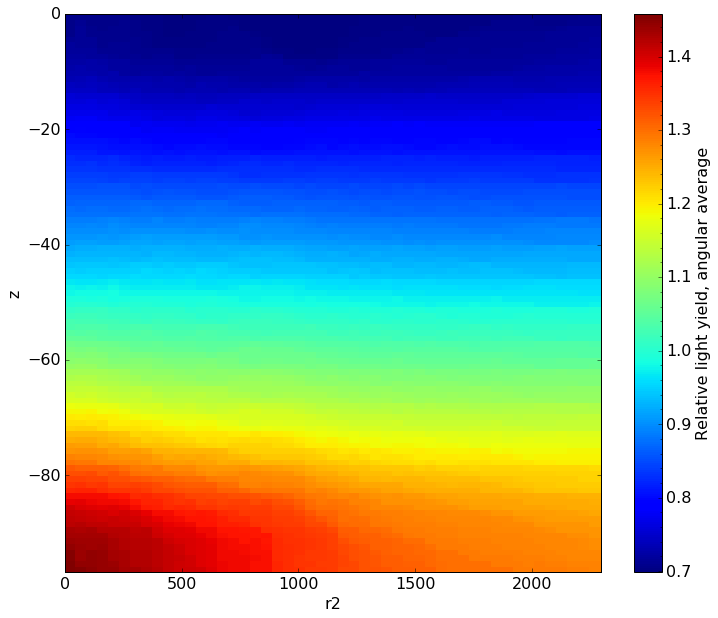

In [22]:
mh.plot(cblabel='Relative light yield, angular average')

In [23]:
import pickle
with open('s1_lce_rz_precomputed_kr83m_sep29_doublez.pkl', mode='wb') as outfile:
    pickle.dump(mh, outfile)

# WIMP spectra

In [ ]:
from wimpy.xenon.wimps import wimp_recoil_spectrum
es = np.linspace(1, 100, int(1e3))

wimp_masses = [7, 10, 20, 50, 100, 200, 1000]
for i, m in enumerate(wimp_masses):
    rates = wimp_recoil_spectrum(es, sigma=1e-45, mass=m)
    pd.DataFrame(np.vstack([es, rates]).T, 
                 columns=['kev', 'events_per_day']).to_csv('wimp_%dgev_1e-45cm2.csv' % m)
    plt.plot(es, rates, color=plt.cm.jet(i/(len(wimp_masses) - 1)), label='%d GeV' % m)
plt.yscale('log')
plt.ylim(1e-11, 1e-2)
plt.legend(loc='upper right')
plt.show()

We stop signal generation at 1 keV, for conservativeness. (we could have also done this by assuming Leff is always 0 below 1 keV)

In [ ]:
# from wimpy.model import Model
# from wimpy.xenon.base_model import config, nr_ignore_settings

# m = 6
# config['sources'] = [dict({'energy_distribution': 'wimp_%dgev_1e-45.pkl' % m,   # TODO: generate and save on the fly
#                            'color': 'red',
#                            'recoil_type': 'nr',
#                            'name': 'wimp_%dgev' % m,
#                            'n_events_for_pdf': 5e6,
#                            'ignore_settings': nr_ignore_settings,
#                            'label': '%d GeV WIMP' % m})]

# m = Model(config)

# Background spectra

In [ ]:
es = np.linspace(1, 100, int(1e3))
for rates, name in ((6e-8 * 10**(-es*1/100) + 3e-6 * 1/(2+es**2), 'radiogenic_neutrons'),
                    (4e-3 * 10**(-es*9/7), 'cnns')):
    plt.plot(es, rates, label=name)
    pd.DataFrame(np.vstack([es, rates]).T, columns=['kev', 'events_per_day']).to_csv('%s.csv' % name)
plt.yscale('log')
plt.legend(loc='upper right')
plt.ylim(1e-11, 1)

In [ ]:
es = np.linspace(1e-9, 15, int(1e3))
rates = np.ones(len(es)) * 2e-4
plt.plot(es, rates, label='ER background')
pd.DataFrame(np.vstack([es[mask], rates[mask]]).T, columns=['kev', 'events_per_day']).to_csv('er_bg.csv')
plt.yscale('log')
plt.legend(loc='upper right')
plt.ylim(1e-11, 1)

# Leff

Leff was curve traced from figure 1c in : https://xecluster.lngs.infn.it/dokuwiki/doku.php?id=xenon:xenon1t:sim:notes:digangi:sensitivity-profile-likelihood-ratio

# Qy

In [ ]:
def nr_electron_yield(recoil_energies):
    """Qy from Chris' wimpstat, which is apparently taken from some unidentified C code (given semicolons at linebreaks)
    recoil_energies and cutoff_energy are in keV, answer is in number of electrons produced at the interaction point.
    This is apparently a variation on the Bezrukov Qy (looking at RichardW's notes you can see there are many other
    choices which can also be called "Bezrukov").
    """
#     cutoff_energy = config['nr_electron_yield_cutoff_energy']
#     beyond_cutoff = config['nr_electron_yield_behaviour_below_cutoff']
#     if cutoff_energy > 0 and beyond_cutoff == 'const':
#         recoil_energies = np.clip(recoil_energies, cutoff_energy, float('inf'))

    ep = recoil_energies * (1.05 * np.power(10.,-3.))
    k = 1.65e-1
    se = k * np.sqrt(ep)
    sn = np.log(1 + 1.1383 * 1.068 * ep)
    sn /= 2 *(1.068 * ep + 0.01321 * np.power((1.068 * ep),0.21226) + 0.19593*np.power((1.068*ep),0.5))
    ratio = 1.09
    g = 0.032
    b = 1.38e5

    squiggle = se / sn;

    Ni = (b * ep * squiggle)/(1 + ratio);
    Nq = (4./g) * np.log(1 + (g * Ni)/4.);

    answer = Nq/recoil_energies

#     if cutoff_energy > 0 and beyond_cutoff == 'zero':
#         answer[recoil_energies < cutoff_energy] = 0
    return answer

In [ ]:
e = np.logspace(0, 3, 100)
plt.plot(e, nr_electron_yield(e))
plt.xscale('log')
plt.xlabel('Energy (keV)')
plt.ylabel('Electron yield (electrons/keV)')

In [ ]:
pd.DataFrame({'kevnr': e, 'qy': nr_electron_yield(e)}).to_csv('qy_bezrukov.csv')

# ER photon yields

In [ ]:
npz = np.load('nest_ER_photon_yield.npz')    # Obtained using Bart's histogram ripper
data_at_voltage = sorted([(int(k.split(' ')[0]), v) for k, v in npz.items()])
for voltage, (x, y) in data_at_voltage:   
    x = 10**x
    with open('beta_photon_yield_nest_%dV.csv' % voltage, mode='w') as out:
        out.write("# NEST photon yield for betas at %d V\n")
        out.write("# Curve traced from figure 1, upper right, using Bart's histogramripper.\n")
        out.write("# Jelle, 25 July 2017.\n")
        pd.DataFrame({'kever': x, 'yield': y}).to_csv(out)
    plt.plot(x, y, label=voltage)
plt.legend(loc='upper left')
plt.xscale('log')